# Task: Riconoscimento automatico di una review positiva o negativa;

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os


## Get reviews dataset

In [71]:
df_review = pd.read_csv('./dataset/review_dropped.csv')

In [72]:
# review_id // string, 22 character unique review id
# user_id // string, 22 character unique user id, maps to the user in user.json
# business_id // string, 22 character business id, maps to business in business.json
# stars // integer, star rating
# date // string, date formatted YYYY-MM-DD
# text // string, the review itself
# useful // integer, number of useful votes received by review
# funny // integer, number of funny votes received by review
# cool // integer, number of cool votes received by review

In [73]:
# Drop some rows in order to increment performances

# df_review = df_review.iloc[460000:, :]
df_review = df_review.iloc[499000:, :]
df_review = df_review.reset_index()

df_review.head(5)

,level_0,Unnamed: 0,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,499000,499000,6989282,NIukhO8BR2wACBztNSRDbQ,Ta9o6-WIRDn5KDvZy8XPNA,jMStvE-tQzSpRCAO0nAE6g,1.0,0.0,0.0,0.0,"Do not eat there! Horrible management, staff a...",2019-05-16 03:34:49
1,499001,499001,6989283,H_-EZhZAZqginAR8EkKxIw,k0qcNly5aTjjr__iNdPKBw,beSgKHecMsEyz6iy7gm-9w,5.0,0.0,0.0,0.0,What a great find! Celebrated out anniversary ...,2021-05-17 01:19:06
2,499002,499002,6989284,aeNMLPf1XGedxQLyTwS8Bg,_0EhXpz__Bs5qNckMW8IEw,Meww6RIE4cFL_kG0aRlbAA,5.0,2.0,0.0,1.0,Great happy hour & great food. I had a great t...,2021-05-09 11:23:03
3,499003,499003,6989285,oDrDjpgNDUXAmrYWU6Q1bQ,tfxcBBdKo28s6OAYNJDM6A,mY4i1N0Hm2fjIgU0Eyn11Q,1.0,2.0,0.0,0.0,"I've been dining here for years, but a recent ...",2021-05-17 22:45:45
4,499004,499004,6989286,jbSsvlNW1VGc-o8b3WBjDw,q6CU8yNwSs2ErfhX3DqaNQ,GxlUXBXe-yw6B5Fqf8kgig,3.0,2.0,1.0,1.0,Food was pretty good. Had the southern fried c...,2016-09-19 23:52:02


### Add boolean positive_review to dataset in order to recognize positive review (>= 4 stars)


In [74]:
df_review['review_rating'] = np.where(df_review['stars'] >= 4, 1, 0)

df_review.head(5)


,level_0,Unnamed: 0,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_rating
0,499000,499000,6989282,NIukhO8BR2wACBztNSRDbQ,Ta9o6-WIRDn5KDvZy8XPNA,jMStvE-tQzSpRCAO0nAE6g,1.0,0.0,0.0,0.0,"Do not eat there! Horrible management, staff a...",2019-05-16 03:34:49,0
1,499001,499001,6989283,H_-EZhZAZqginAR8EkKxIw,k0qcNly5aTjjr__iNdPKBw,beSgKHecMsEyz6iy7gm-9w,5.0,0.0,0.0,0.0,What a great find! Celebrated out anniversary ...,2021-05-17 01:19:06,1
2,499002,499002,6989284,aeNMLPf1XGedxQLyTwS8Bg,_0EhXpz__Bs5qNckMW8IEw,Meww6RIE4cFL_kG0aRlbAA,5.0,2.0,0.0,1.0,Great happy hour & great food. I had a great t...,2021-05-09 11:23:03,1
3,499003,499003,6989285,oDrDjpgNDUXAmrYWU6Q1bQ,tfxcBBdKo28s6OAYNJDM6A,mY4i1N0Hm2fjIgU0Eyn11Q,1.0,2.0,0.0,0.0,"I've been dining here for years, but a recent ...",2021-05-17 22:45:45,0
4,499004,499004,6989286,jbSsvlNW1VGc-o8b3WBjDw,q6CU8yNwSs2ErfhX3DqaNQ,GxlUXBXe-yw6B5Fqf8kgig,3.0,2.0,1.0,1.0,Food was pretty good. Had the southern fried c...,2016-09-19 23:52:02,0


### Plot reviews

Positive reviews: 653
Negative reviews: 347


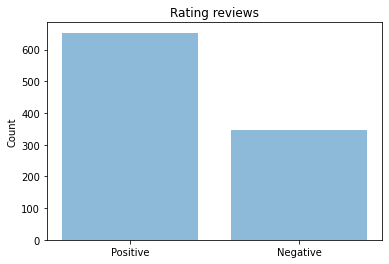

In [75]:
positive_count = (df_review['review_rating'] == 1).sum()
negative_count = (df_review['review_rating'] == 0).sum()

print("Positive reviews:", positive_count)

print("Negative reviews:", negative_count)

objects = ('Positive', 'Negative')
performance = [positive_count, negative_count]
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Rating reviews')

plt.show()



# Text preprocessing


In [76]:
import contractions
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/at181903/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Normalization

### Expand English contractions

In [83]:
def expand_contractions(sentence):
    expanded_words = []

    for word in sentence.split():
        expanded_words.append(contractions.fix(word))

    return ' '.join(expanded_words)


df_review_text = df_review[['text']]

for sentence in df_review_text['text']:
    df_review_text_expanded = df_review_text[['text']].replace(sentence, expand_contractions(sentence))

df_review_text_expanded.head(5)

,text
0,"Do not eat there! Horrible management, staff a..."
1,What a great find! Celebrated out anniversary ...
2,Great happy hour & great food. I had a great t...
3,"I've been dining here for years, but a recent ..."
4,Food was pretty good. Had the southern fried c...


### Tokenize

In [84]:
df_review_text_tokenized = df_review_text_expanded


def tokenize(row):
    return word_tokenize(row['text'])


df_review_text_tokenized['tokenized_text'] = df_review_text_tokenized.apply(tokenize, axis=1)

In [85]:
df_review_text_tokenized.head(5)

,text,tokenized_text
0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,..."
1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann..."
2,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had..."
3,"I've been dining here for years, but a recent ...","[I, 've, been, dining, here, for, years, ,, bu..."
4,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther..."


### Remove puncts

In [90]:
df_review_text_no_punct = df_review_text_tokenized


def remove_punct(row):
  return [word for word in row['tokenized_text'] if word.isalpha()]

df_review_text_no_punct['no_punct_text'] = df_review_text_no_punct.apply(remove_punct, axis=1)

In [91]:
df_review_text_no_punct.head(5)

,text,tokenized_text,no_punct_text
0,"Do not eat there! Horrible management, staff a...","[Do, not, eat, there, !, Horrible, management,...","[Do, not, eat, there, Horrible, management, st..."
1,What a great find! Celebrated out anniversary ...,"[What, a, great, find, !, Celebrated, out, ann...","[What, a, great, find, Celebrated, out, annive..."
2,Great happy hour & great food. I had a great t...,"[Great, happy, hour, &, great, food, ., I, had...","[Great, happy, hour, great, food, I, had, a, g..."
3,"I've been dining here for years, but a recent ...","[I, 've, been, dining, here, for, years, ,, bu...","[I, been, dining, here, for, years, but, a, re..."
4,Food was pretty good. Had the southern fried c...,"[Food, was, pretty, good, ., Had, the, souther...","[Food, was, pretty, good, Had, the, southern, ..."
